In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurements = Base.classes.measurement
stations= Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
this_session = Session(engine)

# Exploratory Climate Analysis

C:\Users\dross\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0, 0.5, 'Rainfall(inches)')

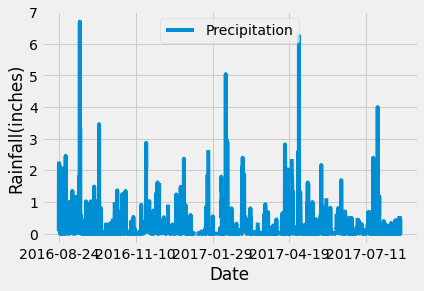

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
Precipition_12mo =  this_session.query(measurements.date, measurements.prcp)
# Calculate the date 1 year ago from the last data point in the database
last = engine.execute('SELECT max(date) FROM measurement').fetchone()
Precipitation_1ya = ((dt.datetime.strptime(last[0], '%Y-%m-%d')) - dt.timedelta(days=365))
# Perform a query to retrieve the data and precipitation scores
Precipitation_Data = this_session.query(measurements.date, measurements.prcp).\
    filter(measurements.date >= Precipitation_1ya).\
order_by(measurements.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
Precipitation_df = pd.DataFrame(Precipitation_Data)
# Precipitation_df.head()
Precipitation_df = Precipitation_df.rename(columns={"prcp":"Precipitation"})
Precipitation_df = Precipitation_df.rename(columns={"date":"Date"})
# Sort the dataframe by date
Precipitation_df = Precipitation_df.sort_values('Date')
# Use Pandas Plotting with Matplotlib to plot the data
Precipitation_df.plot(x='Date', y='Precipitation')
plt.xlabel("Date")
plt.ylabel("Rainfall(inches)")
# print(Precipitation_1ya, Precipitation_Data)
# Precipitation_df.head()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
station_ct = this_session.query(stations.id).count()
print(f"These data were collected from {station_ct} stations")

These data were collected from 9 stations


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
Active_Stations = this_session.query(measurements.station, 
                                     func.count(measurements.tobs))\
                                    .group_by(measurements.station).order_by(
                                    func.count(measurements.tobs).desc()).all()
# List the stations and the counts in descending order.
station_count = len(Active_Stations)
count = 1
for station in Active_Stations:
    print(f"Rank {count}: {station[0]} Records: {station[1]}")
    count = count + 1

Rank 1: USC00519281 Records: 2772
Rank 2: USC00519397 Records: 2724
Rank 3: USC00513117 Records: 2709
Rank 4: USC00519523 Records: 2669
Rank 5: USC00516128 Records: 2612
Rank 6: USC00514830 Records: 2202
Rank 7: USC00511918 Records: 1979
Rank 8: USC00517948 Records: 1372
Rank 9: USC00518838 Records: 511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#USC00519281
MostActive_sta = this_session.query(func.min(measurements.tobs), func.max(measurements.tobs), func.avg(measurements.tobs)).\
    filter(measurements.station == 'USC00519281').all()
print(f"Station {Active_Stations[0][0]}'s lowest recorded temperature was {MostActive_sta[0][0]}, highest temperature {MostActive_sta[0][1]}, and {MostActive_sta[0][2]} was the average")
TopStation = Active_Stations[0][0]

Station USC00519281's lowest recorded temperature was 54.0, highest temperature 85.0, and 71.66378066378067 was the average


In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
TopStation_query = this_session.query(measurements.tobs).\
                    filter(measurements.station == TopStation).\
                    filter(measurements.date >= Precipitation_1ya).all()
TopStation_df = pd.DataFrame(TopStation_query, columns=['tobs'])
TopStation_df.head()

,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


Text(0, 0.5, 'Observations')

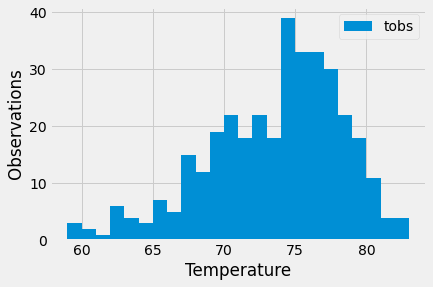

In [16]:
#plot the results as a histogram
TopStation_df.plot.hist(bins=24)
plt.xlabel("Temperature")
plt.ylabel("Observations")

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return this_session.query(func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)).\
        filter(measurements.date >= start_date).filter(measurements.date <= end_date).all()

# function usage example
start_date = '2012-04-15'
end_date = '2012-04-20'
print(calc_temps(start_date, end_date))

[(64.0, 71.9375, 77.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_start_date = str(eval(start_date[0:4])-1) + start_date[4:]
prev_end_date = str(eval(end_date[0:4])-1) + end_date[4:]

Temp_min = calc_temps(prev_start_date, prev_end_date)[0][0]
Temp_max = calc_temps(prev_start_date, prev_end_date)[0][1]
Temp_avg = calc_temps(prev_start_date, prev_end_date)[0][2]
Temp_dict = calc_temps(prev_start_date, prev_end_date)[0][0]
print(f"From {prev_start_date} to {prev_end_date}, the minimum temp was {Temp_min}, the maximum {round(Temp_max, 1)}, and the average {Temp_avg}")

From 2011-04-15 to 2011-04-20, the minimum temp was 66.0, the maximum 72.7, and the average 81.0


<function matplotlib.pyplot.show(close=None, block=None)>

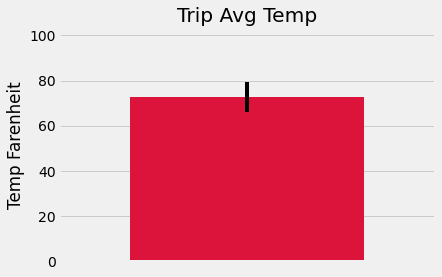

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
bar = ax.bar(1, Temp_max, yerr=(Temp_max-Temp_min), color="crimson")
ax.set(title="Trip Avg Temp", ylabel="Temp Farenheit")
ax.margins(0.3,0.3)
ax.axes.xaxis.set_visible(False)
plt.show

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

LastYear_weatherstations = this_session.query(measurements.station, func.sum(measurements.prcp))\
                            .filter(measurements.date>=prev_start_date).filter(measurements.date<=prev_end_date)\
                            .group_by(measurements.station).order_by(func.sum(measurements.prcp).desc()).all()
print("Station     |  Precipitation")
for weatherstation in LastYear_weatherstations:
    print(f"{weatherstation[0]} |  {weatherstation[1]}")

Station     |  Precipitation
USC00516128 |  0.67
USC00519523 |  0.22
USC00519281 |  0.18
USC00518838 |  0.16
USC00519397 |  0.12
USC00511918 |  0.12
USC00513117 |  0.09
USC00517948 |  0.0
USC00514830 |  0.0
